# Lab : Text pre-processing and features

## Objectives

1. Implement a simple way to represent text data - Bag of words / TF-IDF
2. Use pre-processing tools from Natural Language Processing


## Julian Singer

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re
import numpy as np
import matplotlib.pyplot as plt
#%pip install nltk
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliansinger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Pre-processing and representing documents

### I.1 Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document.

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$.

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document.

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
Bow.toarray()

['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

#### Getting BoW representations

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words).
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations.
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [4]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    tokens = text.split()
    return tokens

# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

In [5]:
# a dictionary taht for each word contains an index number
#the second output is word and freq
#for this one give a number to the word, the column corresponding to the word in the metrics
#so the index that sorresponds to each word in this dic is the position it should be tracked in the count function

#count threshold eliminates words that dont appear more than it
#voc threshold is to determine the max number of words considered

def vocabulary(texts, count_threshold=1, voc_threshold=0):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
    """
    word_counts = {}
    for sentence in texts:
      #print(sentence)
      words = sentence.split()
      for word in words:
        #print(word)
        word_counts[word] = word_counts.get(word, 0) + 1
    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}
    words2 = sorted(filtered_word_counts.keys(), key=word_counts.get, reverse=True)
    # We add a specific token to be able to represent new words when working on validation / testing !
    if voc_threshold > 0:
        words2 = words2[:voc_threshold] + ['UNK']
    else:
        words2 = words2 + ['UNK']
    vocabulary = {word: index for index, word in enumerate(words2)}
    return vocabulary, {word: filtered_word_counts.get(word, 0) for word in vocabulary}

In [6]:
voc, _ = vocabulary(corpus, count_threshold = 0)
print(voc)

{'down': 0, 'the': 1, 'I': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}


In [7]:
def count_words(texts, vocabulary):
    # Initialize the matrix
    n_samples = len(texts)
    n_features = len(vocabulary)
    counts = np.zeros((n_samples, n_features))
    for i, text in enumerate(texts):
      for word in text.split():
            if word in vocabulary:
                word_index = vocabulary[word]
                counts[i][word_index] += 1
    return counts

In [8]:
X = count_words(corpus, voc)
print(X)

[[2. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 2. 1. 0. 0. 1. 1. 0. 0. 0.]]


### I.2 Improving representations: by reweighting and filtering

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account.

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course.
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity.

**Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with !**

In [9]:
# Example
vectorizer_ex = CountVectorizer(max_features=30000, analyzer='word', ngram_range=(2, 3), stop_words=None)
Bow_ex = vectorizer_ex.fit_transform(corpus)
print(vectorizer_ex.get_feature_names_out())
Bow_ex.toarray()

['down down' 'down down the' 'down the' 'down the avenue'
 'down the boulevard' 'down the city' 'down the the' 'ran down'
 'ran down the' 'the avenue' 'the boulevard' 'the city' 'the the'
 'the the avenue' 'walk down' 'walk down the' 'walked down'
 'walked down down' 'walked down the']


array([[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]])

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents.

In [10]:
from sklearn.preprocessing import normalize

def tfidf(bow):
    """
    Inverse document frequencies applied to our bag-of-words representations
    """
    # IDF
    d = float(bow.shape[0]) + 1.0
    in_doc = bow.astype(bool).sum(axis=0) + 1.0
    idfs = np.log(d / in_doc) + 1.0
    # TF
    sum_vec = bow.sum(axis=1)
    tfs = bow / np.expand_dims(sum_vec + 1.0, axis=1)
    tf_idf = tfs * np.expand_dims(idfs,axis=0)
    return tf_idf

In [11]:
print(tfidf(Bow.toarray()))

[[0.         0.2821912  0.         0.33333333 0.         0.16666667
  0.         0.2821912 ]
 [0.33862944 0.         0.         0.2        0.         0.2
  0.         0.33862944]
 [0.         0.33862944 0.         0.2        0.41972246 0.2
  0.         0.        ]
 [0.         0.         0.41972246 0.2        0.         0.2
  0.33862944 0.        ]
 [0.2821912  0.         0.         0.16666667 0.         0.33333333
  0.2821912  0.        ]]


In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

In [13]:
tfidfer = TfidfTransformer()
TfIdfBow = tfidfer.fit_transform(Bow)
print(vectorizer.get_feature_names_out())
TfIdfBow.toarray()

['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0.        , 0.51680194, 0.        , 0.61046311, 0.        ,
        0.30523155, 0.        , 0.51680194],
       [0.6088451 , 0.        , 0.        , 0.35959372, 0.        ,
        0.35959372, 0.        , 0.6088451 ],
       [0.        , 0.55607488, 0.        , 0.32842678, 0.68924048,
        0.32842678, 0.        , 0.        ],
       [0.        , 0.        , 0.68924048, 0.32842678, 0.        ,
        0.32842678, 0.55607488, 0.        ],
       [0.51680194, 0.        , 0.        , 0.30523155, 0.        ,
        0.61046311, 0.51680194, 0.        ]])

## II IMDB Data - Sentiment on movie reviews

You can download the dataset from this address: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

### Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [14]:
from glob import glob


# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos
print(f"There are {len(train_texts)} texts in total")


train_texts_labels = np.array([0] * 12500 + [1] * 12500)


There are 25000 texts in total


In [15]:
print(type(train_texts))

<class 'list'>


In [16]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [17]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_texts_reduced_labels = train_texts_labels[0::k]

print('Number of documents:', len(train_texts_reduced))

Number of documents: 2500


**When training a machine learning model**, we can use a function from ```sklearn```, ```train_test_split```, to separate data into training and validation sets:

In [18]:
import sklearn
from sklearn.model_selection import train_test_split

In [19]:
training_data, validation_data, labels_training, labels_validation = sklearn.model_selection.train_test_split(train_texts_reduced, train_texts_reduced_labels)

Use your function ```count_words``` to transform training and validation data into vectors. Do the same with a ```CountVectorizer```: create and fit the vectorizer to the training data, re-use it on validation data.

In [20]:
training_voc, _ = vocabulary(training_data)
cw_training = count_words(training_data, training_voc)

cw_validation = count_words(validation_data, training_voc) #use training_voc bc in the real world we would have to
    #also permits the later model to work by having the same number of features on the fit and the predict


print(cw_training)
print("=================================")
print(cw_validation)

[[ 2.  2.  2. ...  0.  0.  0.]
 [12.  7.  9. ...  0.  0.  0.]
 [ 9.  5.  6. ...  0.  0.  0.]
 ...
 [ 7.  3.  4. ...  0.  0.  0.]
 [ 7.  3.  4. ...  0.  0.  0.]
 [17. 12.  7. ...  1.  1.  0.]]
[[13.  3.  7. ...  0.  0.  0.]
 [ 9.  4.  4. ...  0.  0.  0.]
 [ 2.  3.  2. ...  0.  0.  0.]
 ...
 [ 7.  3.  8. ...  0.  0.  0.]
 [ 5.  0.  3. ...  0.  0.  0.]
 [15. 10.  3. ...  0.  0.  0.]]


In [21]:
vectorizer = CountVectorizer()

CVtraining = vectorizer.fit_transform(training_data)
CVvalidation = vectorizer.transform(validation_data)

In [22]:
print(CVvalidation)

  (0, 241)	1
  (0, 885)	1
  (0, 1070)	9
  (0, 1574)	2
  (0, 1811)	1
  (0, 1954)	2
  (0, 2145)	1
  (0, 2306)	1
  (0, 2840)	1
  (0, 2849)	6
  (0, 3158)	1
  (0, 3793)	1
  (0, 4073)	1
  (0, 4207)	1
  (0, 4288)	1
  (0, 5056)	1
  (0, 5640)	1
  (0, 6160)	2
  (0, 6575)	1
  (0, 6975)	1
  (0, 6983)	1
  (0, 7467)	1
  (0, 7485)	1
  (0, 8414)	2
  (0, 8428)	1
  :	:
  (624, 22380)	9
  (624, 22398)	1
  (624, 22440)	1
  (624, 22451)	1
  (624, 22739)	1
  (624, 22882)	1
  (624, 23277)	1
  (624, 23400)	1
  (624, 23421)	1
  (624, 23452)	1
  (624, 23467)	1
  (624, 23578)	1
  (624, 23694)	1
  (624, 23784)	1
  (624, 23989)	6
  (624, 24176)	1
  (624, 24187)	1
  (624, 24221)	1
  (624, 24226)	1
  (624, 24283)	1
  (624, 24364)	1
  (624, 24375)	3
  (624, 24458)	1
  (624, 24498)	1
  (624, 24654)	1


We are going to use the scikit-learn ```MultinomialNB```, an implementation of the Naive Bayesian model. Experiment on this model with your own representations. Visualize the results with the following tools, and compare with the representations of ```CountVectorizer```:

Accuracy: 0.7632
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       312
           1       0.79      0.73      0.75       313

    accuracy                           0.76       625
   macro avg       0.76      0.76      0.76       625
weighted avg       0.76      0.76      0.76       625

[[250  62]
 [ 86 227]]


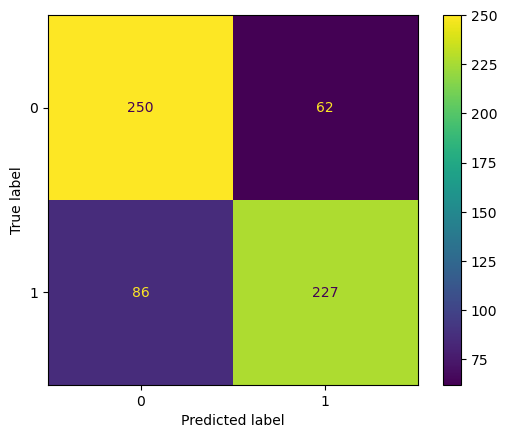

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

#using my count_words vectors to compare with the CountVectorizer
MNB = MultinomialNB()
MNB.fit(cw_training, labels_training)
y_pred = MNB.predict(cw_validation)

accuracy = accuracy_score(labels_validation, y_pred)

print("Accuracy:", accuracy)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(labels_validation, y_pred))
cm = confusion_matrix(labels_validation, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Accuracy: 0.7728
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       312
           1       0.79      0.74      0.76       313

    accuracy                           0.77       625
   macro avg       0.77      0.77      0.77       625
weighted avg       0.77      0.77      0.77       625



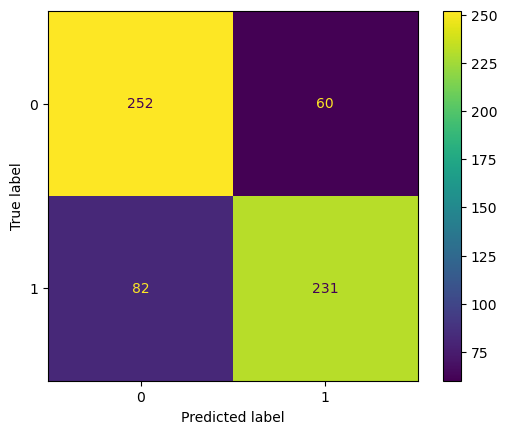

In [24]:
#using CountVectorizer to compare with above results from my count_words vectors

MNBCV = MultinomialNB()
MNBCV.fit(CVtraining, labels_training)
y_pred = MNBCV.predict(CVvalidation)

accuracy = accuracy_score(labels_validation, y_pred)

print("Accuracy:", accuracy)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(labels_validation, y_pred))
cm = confusion_matrix(labels_validation, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

- Here, what is the naïve hypothesis ?
- Let us look at the *features* built by the ```vectorizer```. How can we improve them ?

In [25]:
print(vectorizer.get_feature_names_out()[:600])

['00' '000' '00001' '007' '0079' '0080' '0083' '01' '02' '05' '08' '09'
 '10' '100' '1000' '1000000' '100m' '101' '102' '103' '105' '10mil' '10th'
 '11' '110' '112' '12' '120' '1200f' '123' '125' '12s' '12th' '13' '130'
 '13th' '14' '145' '147' '14ieme' '15' '150' '16' '161' '1692' '16th' '17'
 '1700' '1794' '1798' '17th' '18' '180' '1800' '1814' '1824' '1840' '1850'
 '1864' '1880' '1880s' '1892' '1895' '1897' '18th' '19' '1911' '1912'
 '1914' '1916' '1919' '1920' '1920s' '1921' '1922' '1924' '1927' '1928'
 '1929' '1930' '1930s' '1931' '1932' '1933' '1934' '1936' '1937' '1938'
 '1939' '1940' '1940s' '1941' '1942' '1943' '1944' '1945' '1946' '1947'
 '1948' '1949' '1950' '1950s' '1951' '1952' '1953' '1954' '1955' '1956'
 '1957' '1958' '1959' '1960' '1960s' '1962' '1963' '1964' '1965' '1966'
 '1967' '1968' '1969' '1970' '1970s' '1971' '1972' '1973' '1974' '1975'
 '1976' '1977' '1978' '1979' '1980' '1980s' '1981' '1982' '1983' '1984'
 '1985' '1986' '1987' '1988' '1989' '1990' '1990s' '1991

**Answer:**

I think that the naive hypothesis is that words are looked at as positive or negative and having only one meaning. The context around a word can change its meaning however. If a word has a positive meaning but is used in a different context in negative documents it can affect the way the model makes its predictions by associating a positive word with negativity. For example, in the text sampled in neg/0_3.txt, the word terrific appears, which is a positive word generally, however the context is used to show negativity, thus associating a positive word with negative meaning. If this is prevalent throughout the training data, then the assumption that words have one meaning would cause the model to associate words that are positive often in the test data but negative in the training data with negativity, and this would affect the accuracy of the prediction as the prediction would be negative when in fact it should be positive.

From analyzing the features of vectorizer, I believe that in order to improve them the best path would be to ignore parts of each text used to categorize them as positive or negative. Based on what I have seen in this case if the texts were filtered to remove words that are ambiguous it might have a positive effect on the results of vectorizer, as certain words change between positive and negative meaning and can create a bias in the model as I explained in the naive hypothesis.

Finally, re-do the experiments with the **tf-idf** representations !

Accuracy: 0.7792
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       312
           1       0.86      0.66      0.75       313

    accuracy                           0.78       625
   macro avg       0.79      0.78      0.78       625
weighted avg       0.79      0.78      0.78       625



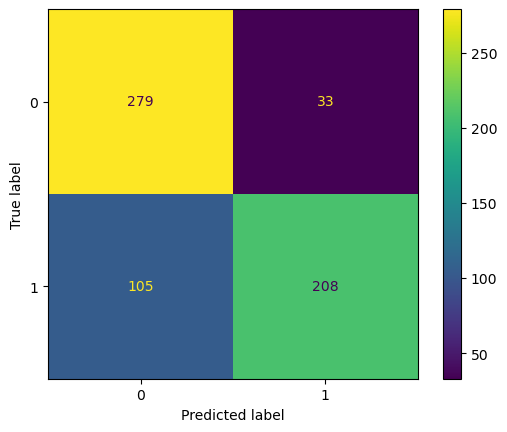

In [26]:
#using my count_words vectors to compare with the CountVectorizer

tfidfer = TfidfTransformer()
tfidfTrain = tfidfer.fit_transform(cw_training)
tfidfValidation= tfidfer.transform(cw_validation)

mnb = MultinomialNB()
mnb.fit(tfidfTrain, labels_training)
y_pred = mnb.predict(tfidfValidation)


accuracy = accuracy_score(labels_validation, y_pred)
print("Accuracy:", accuracy)

print(classification_report(labels_validation, y_pred))
cm = confusion_matrix(labels_validation, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()

Accuracy: 0.784
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       312
           1       0.86      0.68      0.76       313

    accuracy                           0.78       625
   macro avg       0.80      0.78      0.78       625
weighted avg       0.80      0.78      0.78       625



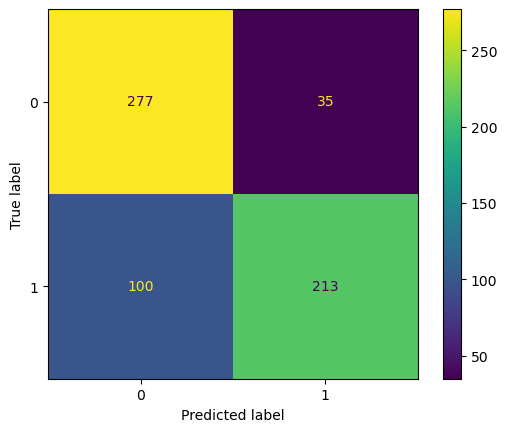

In [27]:
#using CountVectorizer to compare with results of my count_words vectors

tfidferCV = TfidfTransformer()
tfidfTrainCV = tfidferCV.fit_transform(CVtraining)
tfidfValidationCV= tfidferCV.transform(CVvalidation)

mnbCV = MultinomialNB()
mnbCV.fit(tfidfTrainCV, labels_training)
y_pred = mnbCV.predict(tfidfValidationCV)


accuracy = accuracy_score(labels_validation, y_pred)
print("Accuracy:", accuracy)

print(classification_report(labels_validation, y_pred))
cm = confusion_matrix(labels_validation, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()

I ran everything multiple times, which often resulted in nearly the same accuracy score for with tfidf and without tfidf, with tfidf being slightly better. I expected tfidf to perform better since the data is sparse, but I expected it to be a larger difference than it was. There were a few occassions where tfidf performed worse, but they were uncommon. Additionally, using the vectors from CountVectorizer was more accurate than using the vectors from count_words most often.